In [25]:
import os
import datetime as dt
import pandas as pd
import numpy as np
import time
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

main_dir = os.getcwd()
os.chdir(main_dir + '\\Data Collection')
cad_dir = main_dir + '\\Historical Queries\\CAD'
usd_dir = main_dir + '\\Historical Queries\\US'
whale_dir = main_dir + '\\Historical Queries\\Whales'

from helpers import *
from yahoo_query import *

os.chdir(main_dir)

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

In [2]:
def create_dgi(annual_data):
    dgi_data = annual_data[['totalLiab',
                             'totalStockholderEquity',
                             'longTermInvestments',
                             'shortTermInvestments',
                             'netIncome','operatingIncome',
                             'totalRevenue','dividendsPaid',
                             'investments','Underlying']]
    dgi_data['dividendsPaid'] = -dgi_data['dividendsPaid']

    dgi_data['payoutRatio'] = dgi_data.dividendsPaid/dgi_data.netIncome
    dgi_data['debtEquityRatio'] = dgi_data.totalLiab/dgi_data.totalStockholderEquity
    dgi_data['netMargin'] = dgi_data.netIncome/dgi_data.totalRevenue
    dgi_data['roic'] = dgi_data.operatingIncome/(dgi_data.longTermInvestments + dgi_data.shortTermInvestments)

    dgi_data = dgi_data[['Underlying','payoutRatio','debtEquityRatio','netMargin','roic','dividendsPaid']]
    return dgi_data

# DGI Portion

def dgi_scores(annual_df,keystats, min_dgi_score):
    dgi_df = create_dgi(annual_df).fillna(0).replace(-np.inf,0).replace(np.inf,0)

    dgi_df_scores = pd.DataFrame(columns = ['divGrowth','payoutChange','payoutRatio',
                                             'debtEquityRatio','netMargin','roic'],
                                  index = dgi_df.Underlying.drop_duplicates().tolist()).fillna(0)

    for ticker in dgi_df.Underlying.drop_duplicates():
        curr_dgi = dgi_df[dgi_df.Underlying == ticker].sort_index()
        if len(curr_dgi) - 1:
            if sum(curr_dgi['dividendsPaid'].pct_change() >= 0.02) == len(curr_dgi) -1:
                dgi_df_scores.loc[ticker, 'divGrowth'] = 1
            if sum(curr_dgi.payoutRatio.pct_change() <= 1) == len(curr_dgi) - 1:
                dgi_df_scores.loc[ticker, 'payoutChange'] = 1
            if curr_dgi.payoutRatio.tail(3).mean() <= 0.6:
                dgi_df_scores.loc[ticker, 'payoutRatio'] = 1
            if sum(curr_dgi.debtEquityRatio.tail(3) <= 1.5) == len(curr_dgi) - 1:
                dgi_df_scores.loc[ticker, 'debtEquityRatio'] = 1
            if sum(curr_dgi.netMargin.tail(3) >= 0.07) == len(curr_dgi) - 1:
                dgi_df_scores.loc[ticker, 'netMargin'] = 1
            if sum(curr_dgi.roic.tail(3) >= 0.2) == len(curr_dgi) - 1:
                dgi_df_scores.loc[ticker, 'roic'] = 1

    dgi_df_scores['score'] = dgi_df_scores.sum(axis = 1)
    dgi_df_scores = dgi_df_scores[dgi_df_scores.score >= min_dgi_score].join(keystats[['currentPrice','returnOnAssets',
                                                                                       'returnOnEquity','sector']])

    dgi_df_scores = dgi_df_scores.sort_values('returnOnAssets', ascending = False)
    dgi_df_scores['roaRank'] = range(1,len(dgi_df_scores) + 1)
    dgi_df_scores = dgi_df_scores.sort_values('returnOnEquity', ascending = False)
    dgi_df_scores['roeRank'] = range(1,len(dgi_df_scores) + 1)
    dgi_df_scores['roRank'] = dgi_df_scores.roaRank + dgi_df_scores.roeRank
    dgi_df_scores = dgi_df_scores.sort_values('roRank')
    return dgi_df_scores[['currentPrice','score','roRank','sector']]

# filterd_dgi = dgi_df[(dgi_df['debtEquityAvg'] <= 1.5) &
#        (dgi_df['divGrowth'] >= 0.03) &
#        (dgi_df['payoutChange'] <= 0) &
#        (dgi_df['payoutAvg'] <= 0.6) & (dgi_df['payoutAvg'] >= 0) &
#        (dgi_df['netMarginAvg'] >= 0.07) &
#        (dgi_df['roicAvg'] >= 0.2)].sort_values('divGrowth', ascending = False)



# LEAPs Portion

def leaps_scores(data_df, keystats, min_score):
    try:
        df = data_df[['Underlying', 'earnings', 'netIncome','totalRevenue','totalStockholderEquity']]
    except:
        df = data_df[['Underlying', 'epsActual', 'netIncome','totalRevenue','totalStockholderEquity']]
    ks = keystats[['52WeekChange','currentPrice','sector','forwardPE','forwardEps','pegRatio']]
    ks['52WeekChange'] = pd.to_numeric(ks['52WeekChange'].replace('Infinity',0))

    df['profitMargin'] = df.netIncome/df.totalRevenue
    df['roe'] = df.netIncome/df.totalStockholderEquity

    # us_quarterly[['Underlying', 'retainedEarnings', 'netIncome','totalRevenue','totalStockholderEquity']]

    leap_scores = pd.DataFrame(columns = ['earningsGrowth','profitMargins','profitMarginChange',
                                          'roe','roeChange'],
                               index = df.Underlying.drop_duplicates().tolist()).fillna(0)

    for ticker in df.Underlying.drop_duplicates():
        curr_data = df[df.Underlying == ticker].sort_index()
        curr_len = len(curr_data) - 1
        if curr_len > 1:
            try:
                if sum(curr_data.earnings.pct_change() >= 0.05) == curr_len:
                    leap_scores.loc[ticker, 'earningsGrowth'] = 1
            except:
                if sum(curr_data.epsActual.pct_change() > 0) == curr_len:
                    leap_scores.loc[ticker, 'earningsGrowth'] = 1
            if sum(curr_data.profitMargin.tail(3) >= 0.1) == curr_len:
                leap_scores.loc[ticker, 'profitMargins'] = 1
            if sum(curr_data.profitMargin.pct_change() >= 0) == curr_len:
                leap_scores.loc[ticker, 'profitMarginChange'] = 1
            if sum(curr_data.roe.tail(3) >= 0.1) == curr_len:
                leap_scores.loc[ticker, 'roe'] = 1
            if sum(curr_data.roe.pct_change() >= 0) == curr_len:
                leap_scores.loc[ticker, 'roeChange'] = 1

    leap_scores['score'] = leap_scores.sum(axis = 1)
    leap_scores = leap_scores[leap_scores.score >= min_score].join(ks).sort_values('52WeekChange', ascending = False)
    return leap_scores


# DGI Filter

In [3]:
os.chdir(cad_dir)

file_date = '2018-10-01'
cad_annual = pd.read_csv('cad_annual_{}.csv'.format(file_date), index_col = 0)
cad_keystats = pd.read_csv('cad_keystats_{}.csv'.format(file_date), index_col = 0)
cad_quarterly = pd.read_csv('cad_quarterly_{}.csv'.format(file_date), index_col = 0)

os.chdir(main_dir)

os.chdir(usd_dir)

file_date = '2018-10-01'
us_annual = pd.read_csv('us_annual_{}.csv'.format(file_date), index_col = 0)
us_keystats = pd.read_csv('us_keystats_{}.csv'.format(file_date), index_col = 0)
us_quarterly = pd.read_csv('us_quarterly_{}.csv'.format(file_date), index_col = 0)

os.chdir(main_dir)

os.chdir(whale_dir)

file_date = '2018-09-30'
whale_df = pd.read_csv('whales {}.csv'.format(file_date), index_col = 0)

hedgeFunds = whale_df[whale_df.index == 'hedgeFunds'].dropna()
hedgeFunds.index = hedgeFunds.ticker

allFunds = whale_df[whale_df.index == 'allFirms'].dropna()
allFunds.index = allFunds.ticker

os.chdir(main_dir)

In [4]:
cad_dgi_scores = dgi_scores(cad_annual, cad_keystats, 4)
print("CAD")
cad_dgi_scores.head(20).join(cad_keystats[['forwardPE','forwardEps','pegRatio']])

C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#index

CAD


,currentPrice,score,roRank,sector,forwardPE,forwardEps,pegRatio
TCN.TO,10.88,4,8,Real Estate,12.505747,0.87,NaN
BAD.TO,29.60,4,10,Industrials,15.336788,1.93,NaN
WTE.TO,26.84,4,11,Basic Materials,14.586956,1.84,NaN
CNR.TO,115.90,5,12,Industrials,18.573719,6.24,2.31
LUC.TO,2.16,4,12,Basic Materials,16.615385,0.13,-10.89
MG.TO,67.85,4,20,Consumer Cyclical,9.095174,7.46,2.66
ENGH.TO,82.07,5,21,Technology,34.19583,2.40,5.74
TIH.TO,66.77,4,21,Industrials,19.077143,3.50,0.98
MRU.TO,40.18,4,22,Consumer Defensive,13.80756,2.91,2.01
RCH.TO,29.90,5,24,Consumer Cyclical,21.357143,1.40,1.51


In [5]:
us_dgi_score = dgi_scores(us_annual, us_keystats, 5)
print("USD")
us_dgi_score.head(20).join(us_keystats[['forwardPE','forwardEps','pegRatio']]).sort_values('roRank')

C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#index

USD


,currentPrice,score,roRank,sector,forwardPE,forwardEps,pegRatio
MA,222.61,5,4,Financial Services,29.681334,7.50,1.53
INTU,227.40,5,7,Technology,31.065573,7.32,2.34
TXN,107.29,6,8,Technology,17.388979,6.17,1.30
SBUX,56.84,5,12,Consumer Cyclical,21.530302,2.64,1.72
AMAT,38.65,5,13,Technology,9.009324,4.29,0.49
ACN,170.20,5,15,Technology,21.4628,7.93,2.81
MKTX,178.49,5,19,Financial Services,34.45753,5.18,1.61
ROL,60.69,5,22,Industrials,49.7459,1.22,5.64
AAPL,225.74,5,24,Technology,16.477373,13.70,1.78
SEIC,61.10,5,24,Financial Services,18.184525,3.36,1.63


In [6]:
us_dgi_picks = us_dgi_score.head(20).join(us_keystats[['forwardPE',
                                        'forwardEps',
                                        'pegRatio']]).sort_values('roRank').join(hedgeFunds[['numOfFirmsHoldingInTop10',
                                                                                             'numOfHolders',
                                                                                             'fundNumPercentChange',
                                                                                             'fundsCreatingNewPos',
                                                                                             'fundsAddingPos',
                                                                                             'fundsClosingPos',
                                                                                             'fundsReducingPos']]).sort_values('fundNumPercentChange', 
                                                                                                                               ascending = False)


us_dgi_picks

,currentPrice,score,roRank,sector,forwardPE,forwardEps,pegRatio,numOfFirmsHoldingInTop10,numOfHolders,fundNumPercentChange,fundsCreatingNewPos,fundsAddingPos,fundsClosingPos,fundsReducingPos
BKE,23.05,5,36,Consumer Cyclical,11.881443,1.94,-1.06,0.0,26.0,30.89,6.0,10.0,5.0,7.0
INTU,227.40,5,7,Technology,31.065573,7.32,2.34,7.0,90.0,22.34,28.0,26.0,5.0,22.0
SEIC,61.10,5,24,Financial Services,18.184525,3.36,1.63,2.0,43.0,15.90,15.0,14.0,5.0,8.0
SWKS,90.71,5,29,Technology,11.526049,7.87,0.96,2.0,67.0,13.67,12.0,19.0,20.0,30.0
BR,131.95,5,35,Industrials,25.821917,5.11,2.13,4.0,61.0,5.85,18.0,18.0,3.0,20.0
AAPL,225.74,5,24,Technology,16.477373,13.70,1.78,91.0,262.0,1.33,23.0,91.0,22.0,117.0
LANC,149.21,5,41,Consumer Defensive,27.079855,5.51,9.68,0.0,18.0,0.96,2.0,6.0,7.0,9.0
SBUX,56.84,5,12,Consumer Cyclical,21.530302,2.64,1.72,5.0,114.0,0.65,23.0,39.0,26.0,42.0
ACN,170.20,5,15,Technology,21.4628,7.93,2.81,8.0,90.0,-1.98,16.0,27.0,26.0,33.0
JKHY,160.08,5,32,Industrials,35.652565,4.49,3.60,2.0,33.0,-2.43,3.0,14.0,9.0,14.0


In [18]:
prices = []
start_date = dt.datetime(2017,1,1)
for name in us_dgi_picks.index.tolist():
    curr_prices = yahoo_query(name, start_date)
    curr_prices.hist_prices_query()
    prices.append(curr_prices.hist_prices[['{}_close'.format(name)]])

prices = pd.concat(prices, axis = 1)



,BR_close,JKHY_close,V_close,MA_close
2018-10-01,76.645972,62.859475,66.203243,44.692737


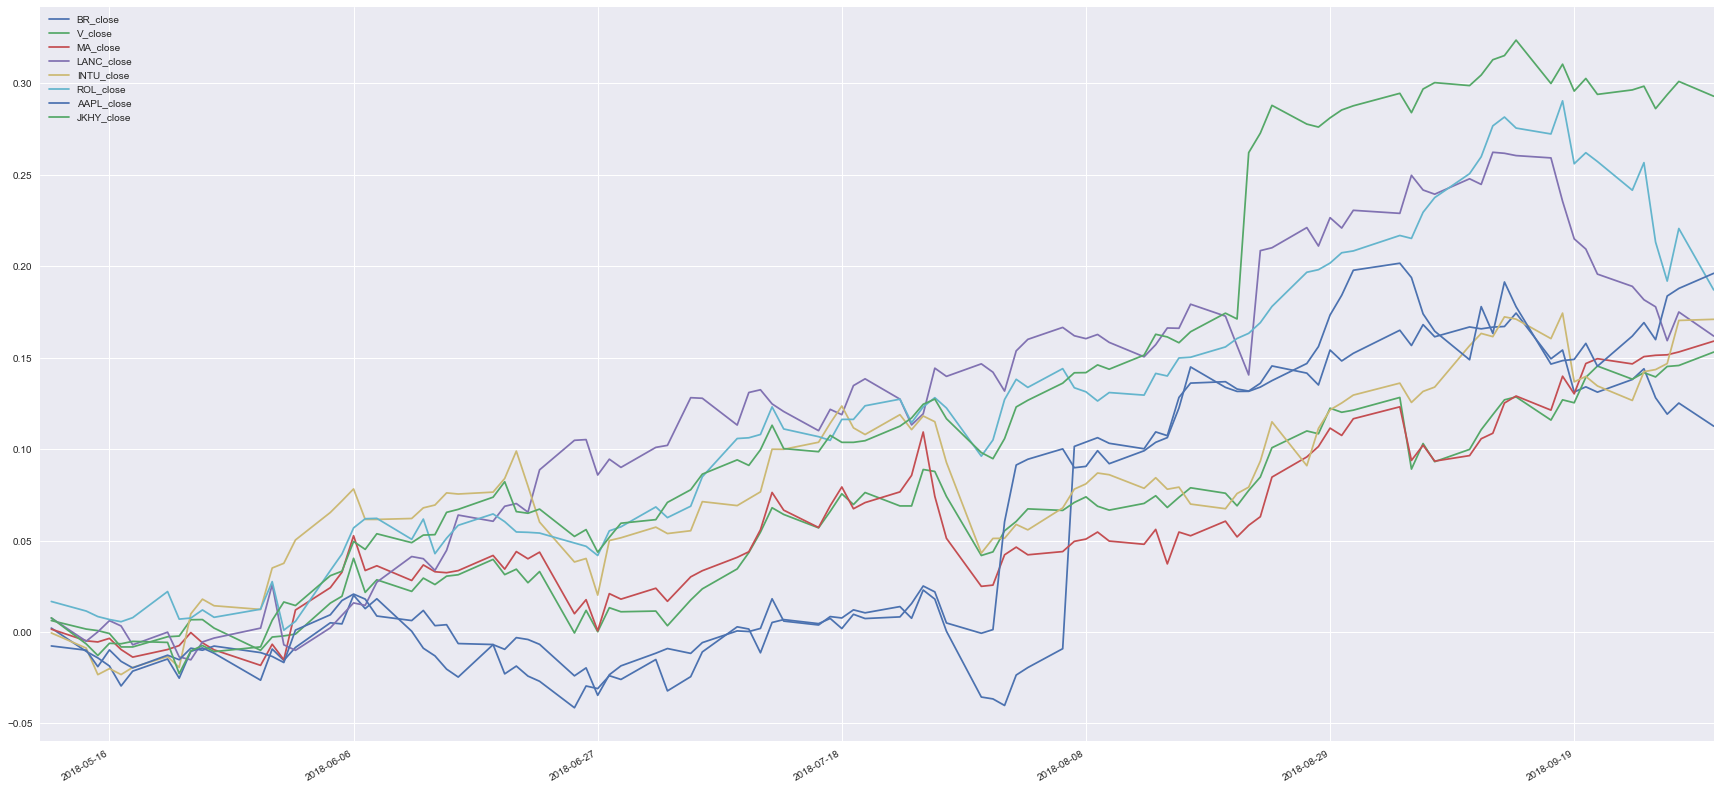

In [46]:
plot_df = ((prices.tail(100).pct_change() + 1).cumprod() - 1)
plot_df[plot_df.tail(1).T.sort_values(plot_df.tail(1).T.columns.tolist()).tail(8).index.tolist()].plot(figsize = (30,15))

10000/prices[['BR_close','JKHY_close','V_close','MA_close']].tail(1)

# LEAPs Filtering

In [7]:
leaps_annual = leaps_scores(us_annual, us_keystats, 4)#.replace('Infinity', 0)
leaps_quarterly = leaps_scores(us_quarterly, us_keystats, 4)#.replace('Infinity', 0)


C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:75: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:76: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#inde

In [8]:
leaps_annual_picks = leaps_annual[(leaps_annual.profitMargins > 0) &
             (leaps_annual.earningsGrowth > 0) &
             (leaps_annual.roe > 0) &
             (leaps_annual.profitMarginChange > 0) &
             (pd.to_numeric(leaps_annual['52WeekChange']) > 0.1)].join(hedgeFunds[['numOfFirmsHoldingInTop10',
                                                                                             'numOfHolders',
                                                                                             'fundNumPercentChange',
                                                                                             'fundsCreatingNewPos',
                                                                                             'fundsAddingPos',
                                                                                             'fundsClosingPos',
                                                                                             'fundsReducingPos']]).sort_values('fundNumPercentChange', 
                                                                                                                               ascending = False)

leaps_annual_picks

,earningsGrowth,profitMargins,profitMarginChange,roe,roeChange,score,52WeekChange,currentPrice,sector,forwardPE,forwardEps,pegRatio,numOfFirmsHoldingInTop10,numOfHolders,fundNumPercentChange,fundsCreatingNewPos,fundsAddingPos,fundsClosingPos,fundsReducingPos
SIVB,1,1,1,1,0,4,0.665940,310.83,Financial Services,15.096163,20.59,1.96,3.0,89.0,20.16,27.0,23.0,4.0,31.0
NTRS,1,1,1,1,0,4,0.112757,102.13,Financial Services,14.165048,7.21,1.03,2.0,69.0,10.33,9.0,24.0,13.0,25.0
ORLY,1,1,1,1,1,5,0.605850,347.32,Consumer Cyclical,19.722885,17.61,1.30,6.0,89.0,4.49,20.0,23.0,11.0,37.0
TREX,1,1,1,1,0,4,0.805788,76.98,Basic Materials,29.837212,2.58,1.38,0.0,21.0,3.17,9.0,4.0,3.0,8.0
ICLR,1,1,1,1,0,4,0.323968,153.75,Healthcare,22.610294,6.80,2.31,2.0,31.0,0.89,7.0,14.0,6.0,8.0
CACC,1,1,1,1,0,4,0.565717,438.07,Financial Services,14.834744,29.53,0.80,10.0,28.0,-1.07,3.0,8.0,8.0,14.0
PAYX,1,1,1,1,1,5,0.228055,73.65,Industrials,23.912338,3.08,3.44,3.0,77.0,-1.33,16.0,24.0,15.0,30.0
LOPE,1,1,1,1,0,4,0.198897,112.80,Consumer Defensive,21.988304,5.13,1.29,5.0,47.0,-1.95,11.0,13.0,4.0,19.0
CCMP,1,1,1,1,0,4,0.258324,103.17,Technology,18.036715,5.72,1.82,0.0,30.0,-3.44,3.0,11.0,8.0,15.0
NEE,1,1,1,1,0,4,0.128458,167.60,Utilities,20.023895,8.37,2.24,5.0,104.0,-7.35,15.0,39.0,17.0,35.0


In [9]:
leaps_quarterly_picks = leaps_quarterly.join(hedgeFunds[['numOfFirmsHoldingInTop10',
                                 'numOfHolders',
                                 'fundNumPercentChange',
                                 'fundsCreatingNewPos',
                                 'fundsAddingPos',
                                 'fundsClosingPos',
                                 'fundsReducingPos']]).sort_values('fundNumPercentChange', ascending = False)

leaps_quarterly_picks

,earningsGrowth,profitMargins,profitMarginChange,roe,roeChange,score,52WeekChange,currentPrice,sector,forwardPE,forwardEps,pegRatio,numOfFirmsHoldingInTop10,numOfHolders,fundNumPercentChange,fundsCreatingNewPos,fundsAddingPos,fundsClosingPos,fundsReducingPos
STOR,1,1,1,0,1,4,0.088703,27.79,Real Estate,29.881721,0.93,4.65,1.0,37.0,116.93,13.0,17.0,3.0,6.0
CBSH,1,1,1,0,1,4,0.134533,66.02,Financial Services,16.463839,4.01,1.97,0.0,21.0,65.39,5.0,6.0,1.0,6.0
CFR,1,1,1,0,1,4,0.084372,104.44,Financial Services,14.132612,7.39,1.13,4.0,45.0,58.61,16.0,16.0,1.0,8.0
NTRS,1,1,1,0,1,4,0.112757,102.13,Financial Services,14.165048,7.21,1.03,2.0,69.0,10.33,9.0,24.0,13.0,25.0
OXY,1,1,1,0,1,4,0.266105,82.17,Energy,14.315331,5.74,0.24,10.0,115.0,6.76,22.0,35.0,4.0,50.0
FIBK,1,1,1,0,1,4,0.150386,44.80,Financial Services,13.7423315,3.26,1.96,0.0,22.0,0.97,3.0,8.0,5.0,9.0
BBT,1,1,1,0,1,4,0.036896,48.54,Financial Services,11.184332,4.34,1.78,2.0,74.0,-10.62,8.0,23.0,19.0,31.0
HCLP,1,1,1,0,1,4,0.075377,10.80,Basic Materials,4.3724694,2.47,-3.09,1.0,13.0,-14.24,1.0,2.0,3.0,5.0
HUN,1,1,1,0,1,4,-0.023071,27.23,Basic Materials,7.847262,3.47,1.00,3.0,68.0,-22.15,6.0,18.0,12.0,40.0
GPMT,1,1,1,0,1,4,0.008981,19.28,Real Estate,10.77095,1.79,0.56,0.0,22.0,-23.57,3.0,5.0,8.0,8.0


# Writing to CSV

In [10]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
os.chdir(main_dir + '\\Single Name Pulls')
datenow = dt.datetime.today().strftime("%Y-%m-%d")
filename = 'single_names {}.xlsx'.format(datenow)

writer = pd.ExcelWriter(filename, engine='xlsxwriter')

# Write each dataframe to a different worksheet.
cad_dgi_scores.to_excel(writer, sheet_name='ca_dgi')
us_dgi_score.to_excel(writer, sheet_name='us_dgi')
leaps_annual.to_excel(writer, sheet_name='leaps_a')
leaps_quarterly.to_excel(writer, sheet_name = 'leaps_q')

# Close the Pandas Excel writer and output the Excel file.


picknames = 'name_picks {}.xlsx'.format(datenow)

writer = pd.ExcelWriter(picknames, engine='xlsxwriter')

# Write each dataframe to a different worksheet.
us_dgi_picks.to_excel(writer, sheet_name='us_dgi')
leaps_annual_picks.to_excel(writer, sheet_name='leaps_a')
leaps_quarterly_picks.to_excel(writer, sheet_name = 'leaps_q')


writer.save()
os.chdir(main_dir)

# Option Selection

In [ ]:

display = 'Score'

strike_range = [25,85]
strikes = np.linspace(strike_range[0],strike_range[1],int((strike_range[1] - strike_range[0])/5) + 1)
dtes = np.linspace(1,90,90)

strikeGrid, dteGrid = np.meshgrid(strikes, dtes)

option_test = pd.DataFrame({'Strike': strikeGrid.flatten(),
                            'DTE': dteGrid.flatten()},
                           index = range(len(strikeGrid.flatten())))

option_test['Type'] = 'call'
option_test['IV'] = 0.6
option_test['Underlying_Price'] = 44.74
option_test = all_greeks(option_test)
option_test['Mid'] = bsm_call(option_test)
option_test['Lambda'] = option_test['Delta']*option_test['Underlying_Price']/option_test['Mid']
option_test['Score'] = (option_test['Theta']*option_test['Vega'])/(option_test['Lambda']*option_test['Gamma'])

scoreGrid = np.array(option_test[display]).reshape(strikeGrid.shape)


surface1 = go.Surface(x = strikeGrid, 
                      y = dteGrid, 
                      z = scoreGrid,
                      name = display)

layout = go.Layout(
                    title='{} Plot'.format(display),
                    autosize=True,
                    showlegend = False,
                    scene=dict(
                        aspectmode = 'manual',
                        aspectratio = dict(x = 2,
                                           y = 2,
                                           z = 1),
                        camera = dict(up = dict(x = 1,
                                                y = 1,
                                                z = 2),
                                      center = dict(x = 0,
                                                    y = 0,
                                                    z = 0),
                                      eye = dict(x = 1,
                                                 y = 1,
                                                 z = 0.5)),
                        xaxis=dict(
                            title='Strike',
                            gridcolor='rgb(255, 255, 255)',
                            zerolinecolor='rgb(255, 255, 255)',
                            showbackground=True,
                            backgroundcolor='rgb(230, 230,230)'
                        ),
                        yaxis=dict(
                            title='DTE',
                            gridcolor='rgb(255, 255, 255)',
                            zerolinecolor='rgb(255, 255, 255)',
                            showbackground=True,
                            backgroundcolor='rgb(230, 230,230)'
                        ),
                        zaxis=dict(
                            title = display,
                            gridcolor='rgb(255, 255, 255)',
                            zerolinecolor='rgb(255, 255, 255)',
                            showbackground=True,
                            backgroundcolor='rgb(230, 230,230)'
                        )
                    )
                )

data = [surface1]
figure = dict(data=data, layout=layout)
iplot(figure)

In [ ]:
calls = all_options('MU', 400,90)
calls = calls[calls.Type == 'call']
calls = all_greeks(calls)
calls['Lambda'] = calls['Delta']*calls['Underlying_Price']/calls['Mid']
calls['Score'] = (calls['Theta']*calls['Vega'])/(calls['Lambda']*calls['Gamma'])

# strikeGrid = calls_plot.Strike.reshape(dte_len,strike_len)
# dteGrid = calls_plot.DTE.reshape(dte_len,strike_len)
# scoreGrid = calls_plot.Score.reshape(dte_len,strike_len)

# calls_plot['Score'] = (calls_plot['Theta']*calls_plot['Vega'])/(calls_plot['Lambda']*calls_plot['Gamma'])

# Earnings Analysis